## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

#### Connect to Database

In [40]:
import psycopg2
import pandas as pd
import numpy as np
import config as cfg
from scipy import stats
import requests
from IPython.display import JSON
import json
import os
from calendar import monthrange
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option("display.max_columns", None)

In [ ]:
# Create a connection to the midterm database 
con = psycopg2.connect(database=cfg.DATABASE, 
                       user=cfg.USER, 
                       password=cfg.PASSWORD,
                       host=cfg.HOST, 
                       port=cfg.PORT)
cur = con.cursor()

In [ ]:
# get flights data by month from 2018,2019 and save to csv
years = ['2018', '2019']
months = [f'{i:02}'for i in range(1,13)]
for year in years:
    for month in months:
        query = f"SELECT * FROM flights WHERE fl_date LIKE '{year}-{month}%'"

        pandas_response = pd.read_sql_query(query, con)

        pandas_response.to_csv(f'data/{month}_{year}_flights.csv')
        print(f'{month}_{year} complete')
        

In [ ]:
# get test data and save to file
query = f"SELECT * FROM flights_test"
pandas_response = pd.read_sql_query(query, con)
pandas_response.to_csv(f"data/{'01'}_{'2020'}_flights.csv")

#### **Task 1**: 
Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [2]:
jan = pd.read_csv('data/01_2019_flights.csv', index_col=0)

# Convert flight date to column to datetime
jan['fl_date'] =  pd.to_datetime(jan['fl_date'], format='%Y/%m/%d')

# Create new column for day of the week ie. 0 = monday
jan['day_of_week'] = jan['fl_date'].dt.dayofweek

In [3]:
jan.dtypes

fl_date                datetime64[ns]
mkt_unique_carrier             object
branded_code_share             object
mkt_carrier                    object
mkt_carrier_fl_num              int64
op_unique_carrier              object
tail_num                       object
op_carrier_fl_num               int64
origin_airport_id               int64
origin                         object
origin_city_name               object
dest_airport_id                 int64
dest                           object
dest_city_name                 object
crs_dep_time                    int64
dep_time                      float64
dep_delay                     float64
taxi_out                      float64
wheels_off                    float64
wheels_on                     float64
taxi_in                       float64
crs_arr_time                    int64
arr_time                      float64
arr_delay                     float64
cancelled                     float64
cancellation_code              object
diverted    

In [4]:
jan.shape

(638649, 43)

In [12]:
x = jan['arr_delay'].isnull()
x.value_counts()

False    617649
True      21000
Name: arr_delay, dtype: int64

In [13]:
jan.dropna(inplace=True,subset=['arr_delay'])

In [14]:
jan[jan['arr_delay'].isnull()]


,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,day_of_week


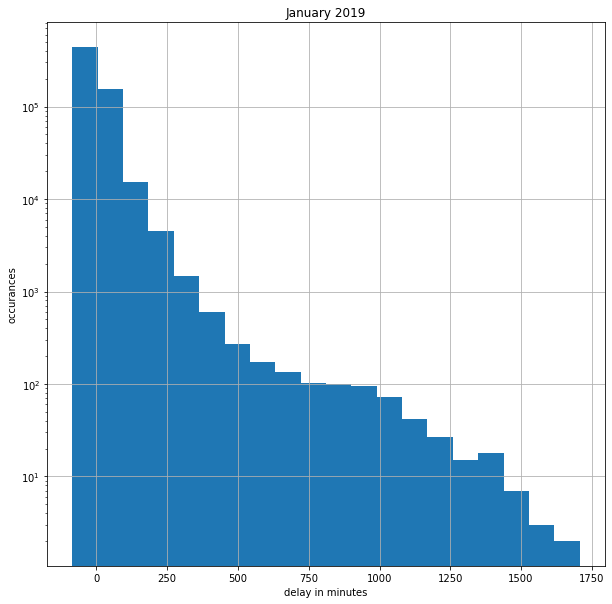

In [29]:
fig, ax = plt.subplots(figsize=(10,10)) 
jan['arr_delay'].hist(bins=20, log=True)
plt.ylabel('occurances')
plt.xlabel('delay in minutes')
plt.title('January 2019')
plt.savefig('hist_2019_01')
plt.show()

In [18]:
value_counts = jan['arr_delay'].value_counts()
value_counts.head(50)

-9.0     17109
-12.0    17044
-11.0    17015
-10.0    16883
-13.0    16665
-14.0    16493
-8.0     16454
-15.0    16139
-7.0     15920
-16.0    15437
-6.0     15294
-5.0     14853
-17.0    14467
-4.0     13697
-18.0    13617
-3.0     13263
-19.0    12659
-2.0     12363
-1.0     11779
-20.0    11741
 0.0     11323
-21.0    10627
 1.0     10358
-22.0     9851
 2.0      9479
 3.0      9004
-23.0     8928
 4.0      8319
-24.0     7993
 5.0      7839
-25.0     7188
 6.0      7109
 7.0      6897
-26.0     6447
 8.0      6446
 9.0      5960
-27.0     5752
 10.0     5572
 11.0     5396
-28.0     4991
 12.0     4855
 13.0     4510
-29.0     4405
 14.0     4340
 15.0     4010
-30.0     3880
 16.0     3844
 17.0     3602
-31.0     3410
 18.0     3366
Name: arr_delay, dtype: int64

In [19]:
jan['arr_delay'].min()

-85.0

In [20]:
normal_test = stats.normaltest(jan['arr_delay'].sample(100), nan_policy='omit')
normal_test

NormaltestResult(statistic=68.52420515273974, pvalue=1.31873615359144e-15)

In [21]:
normal_test = stats.normaltest(jan['arr_delay'], nan_policy='omit')
normal_test

NormaltestResult(statistic=229624.47239632078, pvalue=0.0)

In [22]:
print(f"Arrival delay Mean: {jan['arr_delay'].mean()}")
print(f"Arrival delay Median: {jan['arr_delay'].median()}")
print(f"Arrival delay Standard Deviation: {jan['arr_delay'].std()}")

Arrival delay Mean: 4.714467278340935
Arrival delay Median: -7.0
Arrival delay Standard Deviation: 52.089993263135916


In [26]:
anderson_test = stats.anderson(jan['arr_delay'].sample(1000), dist='expon')
anderson_test

AndersonResult(statistic=inf, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### **Task 2**: 
Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [117]:
# loop through each month. Calculate mean and median of arr_delay. build dataframe with monthstats
years = ['2018', '2019']
months = [f'{i:02}'for i in range(1,13)]
monthly_stats = []
for year in years:
    for month in months:
        month_df = pd.read_csv(f'data/{month}_{year}_flights.csv', index_col=0, low_memory=False)
        month_df.dropna(inplace=True,subset=['arr_delay'])
        monthly_stats.append({'year': year,'month':month, 'mean': month_df['arr_delay'].mean(),'median': month_df['arr_delay'].median(), 'total_flights': month_df['mkt_unique_carrier'].count()})

monthly_stat_df = pd.DataFrame(monthly_stats)

In [118]:
monthly_stat_df.sort_values(['mean'], ascending=False).head(5)

,year,month,mean,median,total_flights
17,2019,06,11.993984,-4.0,677024
7,2018,08,10.082958,-4.0,684505
13,2019,02,9.306549,-4.0,562827
6,2018,07,8.983223,-4.0,686530
18,2019,07,8.971920,-6.0,700359


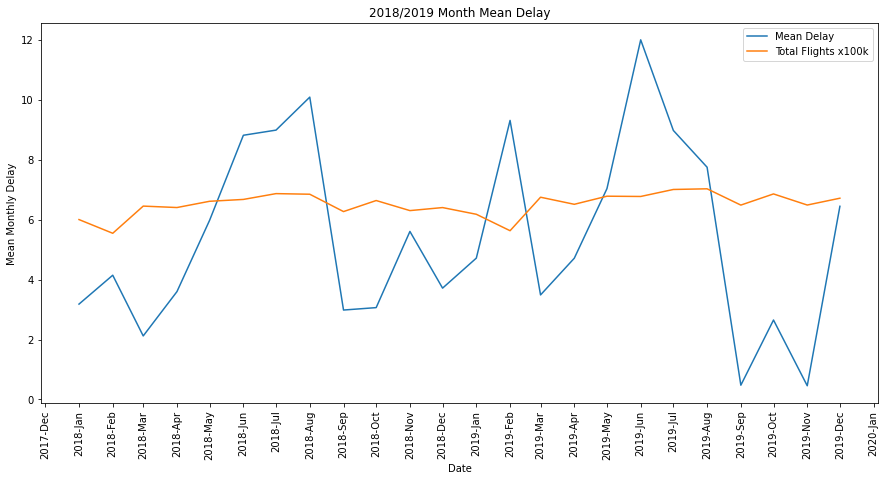

In [170]:
fig, ax = plt.subplots(figsize=(15,7)) 

monthly_stat_df['datetime'] = pd.to_datetime(monthly_stat_df['year']+ ' ' + monthly_stat_df['month'],format='%Y %m')
plt.plot(monthly_stat_df['datetime'],monthly_stat_df['mean'], label='Mean Delay')
plt.plot(monthly_stat_df['datetime'],monthly_stat_df['total_flights']/100000, label='Total Flights x100k')
ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
plt.ylabel('Mean Monthly Delay')
plt.xlabel('Date')
plt.title('2018/2019 Month Mean Delay')
plt.legend()
#plt.savefig('monthly_mean_delay.png')
plt.show()

In [158]:
# compare mean monthly delay to total precip from destination and origin
years = ['2019']
months = ['01']
daily_stats_df = pd.DataFrame()
for year in years:
    for month in months:
        month_df = pd.read_csv(f'data/{month}_{year}_flights_weather.csv', low_memory=False)
        month_df.dropna(inplace=True,subset=['arr_delay'])
        grouped_df = month_df.groupby(['date']).agg({'arr_delay': 'mean', 
                                                     'mkt_unique_carrier': 'count', 
                                                     'precip_origin': 'sum', 
                                                     'precip_dest': 'sum', 
                                                     'visibility_origin': 'mean', 
                                                     'visibility_dest': 'mean' }).reset_index()
        daily_stats_df= pd.concat([daily_stats_df,grouped_df], ignore_index=True)


In [159]:
daily_stats_df.head()

,date,arr_delay,mkt_unique_carrier,precip_origin,precip_dest,visibility_origin,visibility_dest
0,2019-01-01,6.577255,19494,592.0,1400.2,9.435365,9.405509
1,2019-01-02,8.737574,22090,4059.5,4233.6,9.103984,9.075283
2,2019-01-03,2.651218,21188,3554.4,3364.3,8.994950,9.078016
3,2019-01-04,-2.449679,21333,3259.0,3264.3,9.456663,9.447476
4,2019-01-05,1.653936,18355,2574.2,2635.2,9.394443,9.412803


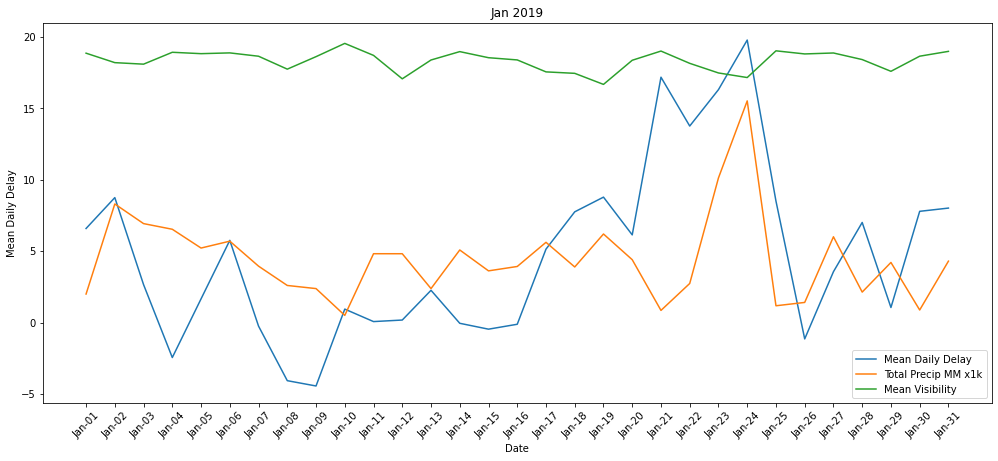

In [167]:
fig, ax = plt.subplots(figsize=(17,7)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.plot(daily_stats_df['date'],daily_stats_df['arr_delay'], label='Mean Daily Delay')
plt.plot(daily_stats_df['date'], (daily_stats_df['precip_origin'] + daily_stats_df['precip_dest'])/ 1000 ,label='Total Precip MM x1k')
plt.plot(daily_stats_df['date'], (daily_stats_df['visibility_origin'] + daily_stats_df['visibility_dest']),label='Mean Visibility')
plt.ylabel('Mean Daily Delay')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Jan 2019')
plt.legend()
#plt.savefig('daily_delay_mean_vs_precip_vs_visibility_jan_2019')
plt.show()

In [127]:
# loop through each month. Calculate mean and median of arr_delay per day. build dataframe with monthstats
years = ['2018', '2019']
months = [f'{i:02}'for i in range(1,13)]

monthly_stats_df = pd.DataFrame()

for year in years:
    for month in months:
        month_df = pd.read_csv(f'data/{month}_{year}_flights.csv', index_col=0, low_memory=False)
        month_df.dropna(inplace=True,subset=['arr_delay'])
        daily_means = month_df.groupby(['fl_date']).agg({'arr_delay': 'mean', 'mkt_unique_carrier': 'count'}).reset_index()
        monthly_stats_df= pd.concat([monthly_stats_df,daily_means], ignore_index=True)
    


In [83]:
monthly_stats_df.to_csv('data/daily_delay_mean.csv')

In [84]:
monthly_stats_df.head()

,fl_date,arr_delay,mkt_unique_carrier
0,2018-01-01,14.482766,19090
1,2018-01-02,11.243284,21329
2,2018-01-03,7.190095,20111
3,2018-01-04,2.634698,16589
4,2018-01-05,12.686591,19457


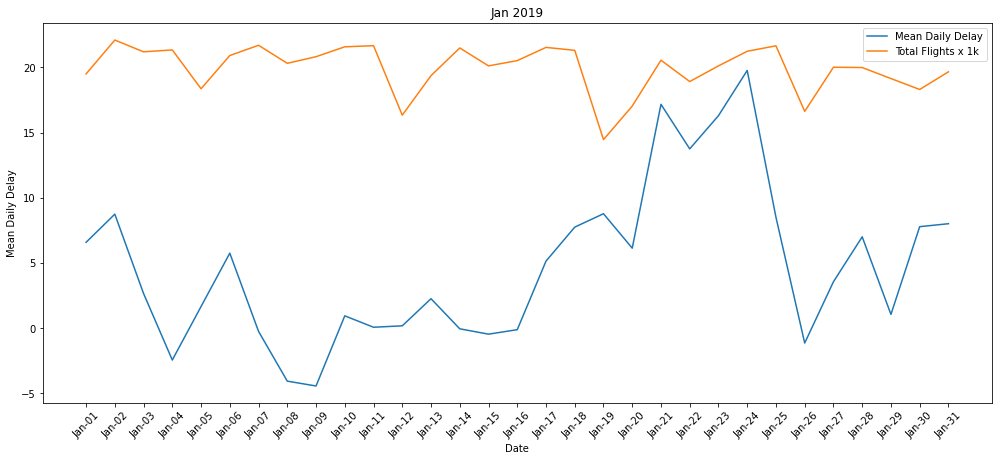

In [105]:
fig, ax = plt.subplots(figsize=(17,7)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
jan_mean_daily_delay = monthly_stats_df[monthly_stats_df['fl_date'].str.contains('2019-01')]
plt.plot(jan_mean_daily_delay['fl_date'],jan_mean_daily_delay['arr_delay'], label='Mean Daily Delay')
plt.plot(jan_mean_daily_delay['fl_date'], jan_mean_daily_delay['mkt_unique_carrier']/1000,label='Total Flights x 1k')
plt.ylabel('Mean Daily Delay')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Jan 2019')
plt.legend()
plt.savefig('daily_delay_mean_vs_flights_jan_2019')
plt.show()

#### **Task 3**: 
Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [172]:
# get weather data for a particular city from startdate to enddate
def get_wwo_weather(city, startdate, enddate):
    params = {'q':city,
              'date': startdate,
              'enddate': enddate, 
              'tp':1, 
              'format': 'json',
              'key': cfg.WEATHER_KEY
             }
    url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"

    response = requests.get(url=url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise

In [ ]:
response = get_wwo_weather('CDC', '2018-01-01', '2018-01-31')

Get weather data for all orgin and destination cities on a particular day

In [173]:
def parse_json_weather(response):
    """ Parses response from wwo_get_weather(). 
        Returns df with hourly weather from all dates in the the response """
    
    # result = response.json()
    result = response
    dates = range(len(result['data']['weather']))
    parsed_weather_df = pd.DataFrame()
    
    for index in dates:
        date = result['data']['weather'][index]['date']
        
        time = [x['time'] for x in result['data']['weather'][index]['hourly']]
        description = [x['weatherDesc'][0]['value'] for x in result['data']['weather'][index]['hourly']]
        precip = [x['precipMM'] for x in result['data']['weather'][index]['hourly']]
        windspeedKmph = [x['windspeedKmph'] for x in result['data']['weather'][index]['hourly']]
        winddirDegree = [x['winddirDegree'] for x in result['data']['weather'][index]['hourly']]
        visibility = [x['visibility'] for x in result['data']['weather'][index]['hourly']]
        DewPointC = [x['DewPointC'] for x in result['data']['weather'][index]['hourly']]
        pressure = [x['pressure'] for x in result['data']['weather'][index]['hourly']]
        cloudcover = [x['cloudcover'] for x in result['data']['weather'][index]['hourly']]
        WindGustKmph = [x['WindGustKmph'] for x in result['data']['weather'][index]['hourly']]
        humidity = [x['humidity'] for x in result['data']['weather'][index]['hourly']]
        tempC = [x['tempC'] for x in result['data']['weather'][index]['hourly']]
        
        df_temp = pd.DataFrame({'date': date, 
                                'time': time, 
                                'description': description, 
                                'precip': precip, 
                                'windspeedKmph': windspeedKmph, 
                                'winddirDegree': winddirDegree,
                                'visibility': visibility,
                                'DewPointC': DewPointC,
                                'pressure': pressure,
                                'cloudcover': cloudcover,
                                'WindGustKmph': WindGustKmph,
                                'humidity': humidity,
                                'tempC': tempC
                               })                                
        
        parsed_weather_df = pd.concat([parsed_weather_df, df_temp])
    return parsed_weather_df

In [ ]:
parse_json_weather(response)

In [174]:
def get_cities_weather(year, month):
    """loop through all departure and arrival cities during month/year and send request for weather for each city. 
    Finally, append weather information to cities_weather[start_date]-[end_date].csv"""
    
    start_date = [f'{year}-{month}-01']
    end_date = [f'{year}-{month}-{monthrange(int(year), int(month))[1]}'] 

    #list of unique cities to iterate through and get weather data
    month_df = pd.read_csv(f'data/{month}_{year}_flights.csv', index_col=0)
    cities = list(set(month_df['origin'].append(month_df['dest'])))

    cities_df = pd.DataFrame()
    result_df = pd.DataFrame()
    index = -1
    errors = []   # track which cities had errors getting weather
    from_file = 0    # number of cities loaded from file
    from_wwo = 0    # number of cities loaded from world weather online

    while index < len(cities) - 1:
        index += 1
        try:
            #open response from file
            with open(f'data/weather_resp/{cities[index]}_{start_date}-{end_date}_weather.json') as f:
                response = json.load(f)
            result_df = parse_json_weather(response)
            from_file += 1
               
        except:
            # get weather from world weather online api if not in file
            try:
                response = get_wwo_weather(cities[index], start_date, end_date)
                #save result to file
                with open(f'data/weather_resp/{cities[index]}_{start_date}-{end_date}_weather.json', 'w') as outfile:
                    json.dump(response, outfile)   
                
                result_df = parse_json_weather(response)
                from_wwo += 1
            except:
                
                errors.append(f"{cities[index]}")
                continue

        

        # add column with the city code    
        result_df['city'] = cities[index]
        cities_df = pd.concat([cities_df, result_df], ignore_index=True)
        print(f"Complete. Errors: {errors} . Opened {from_file} from file, {from_wwo} from wwo.")


    cities_df.to_csv(f'data/{month}_{year}_weather.csv', index=False)

In [ ]:
get_cities_weather('2018', '01')

In [175]:
#convert column in df to datetime
def convert_to_datetime(df, column):
    df.loc[:,column] = [f'{x:04}' for x in df[column]]
    df.loc[:,column].replace(to_replace='2400', value='0000', inplace=True) #replace 2400hr with 0000hr to avoid to_datetime error
    df.loc[:,column] = pd.to_datetime(df['date']+ ' ' + df[column],format='%Y-%m-%d %H%M')
    return df[column]

Testing merging dataframe on departure city

In [177]:
def merge_flights_weather(year, month):
    try:
        joined_df = pd.read_csv(f'data/{month}_{year}_flights_weather.csv')
    except:    
        #load flights
        flights_df = pd.read_csv(f"data/{month}_{year}_flights.csv", index_col=0)
        
        #load weather
        weather_df = pd.read_csv(f"data/{month}_{year}_weather.csv")

        #drop na dep and arr times
        #flights_df.dropna(axis=0, subset=['dep_time', 'arr_time'], inplace=True)
        
        #change 'fl_date' column to 'date' for convert to datetime function next step
        flights_df = flights_df.rename({'fl_date': 'date'}, axis=1)
        
        # convert planned depture time and planned arrival time to datetime
        flights_df['crs_dep_time'] = convert_to_datetime(flights_df, 'crs_dep_time')
        flights_df['crs_arr_time'] = convert_to_datetime(flights_df, 'crs_arr_time')
        weather_df['time'] = convert_to_datetime(weather_df, 'time')

        # create column for dep hr and arr hour to use for merging on
        flights_df['crs_dep_time_hr'] = flights_df['crs_dep_time'].dt.round('H').dt.hour
        flights_df['crs_arr_time_hr'] = flights_df['crs_arr_time'].dt.round('H').dt.hour
        weather_df['time_hr'] = weather_df['time'].dt.round('H').dt.hour

        # merge flights and origin city weather
        dep_joined = pd.merge(flights_df, weather_df, left_on=['date','origin','crs_dep_time_hr'], right_on=['date', 'city', 'time_hr'])
        # merge result with destination city weather
        joined_df = pd.merge(dep_joined, weather_df, left_on=['date','dest','crs_arr_time_hr'], right_on=['date', 'city', 'time_hr'], suffixes=('_origin', '_dest'))

        joined_df.to_csv(f'data/{month}_{year}_flights_weather.csv', index=False)
    return joined_df

In [178]:
merged_df = merge_flights_weather('2019','01')

In [ ]:

corrMatrix = merged_df[cols_to_keep].corr()
fig, ax = plt.subplots(figsize=(18,18)) 
sn.heatmap(corrMatrix, annot=True)
plt.savefig('weather_corr_matrix')
plt.show()


In [ ]:
all_cols = ['date',
            'mkt_unique_carrier',
            'branded_code_share',
            'mkt_carrier',
            'mkt_carrier_fl_num',
            'op_unique_carrier',
            'tail_num',
            'op_carrier_fl_num',
            'origin_airport_id',
            'origin',
            'origin_city_name',
            'dest_airport_id',
            'dest',
            'dest_city_name',
            'crs_dep_time',
            'dep_time',
            'dep_delay',
            'taxi_out',
            'wheels_off',
            'wheels_on',
            'taxi_in',
            'crs_arr_time',
            'arr_time',
            'arr_delay',
            'cancelled',
            'cancellation_code',
            'diverted',
            'dup',
            'crs_elapsed_time',
            'actual_elapsed_time',
            'air_time',
            'flights',
            'distance',
            'carrier_delay',
            'weather_delay',
            'nas_delay',
            'security_delay',
            'late_aircraft_delay',
            'first_dep_time',
            'total_add_gtime',
            'longest_add_gtime',
            'no_name',
            'crs_dep_time_hr',
            'crs_arr_time_hr',
            'time_origin',
            'description_origin',
            'precip_origin',
            'windspeedKmph_origin',
            'winddirDegree_origin',
            'visibility_origin',
            'DewPointC_origin',
            'pressure_origin',
            'cloudcover_origin',
            'WindGustKmph_origin',
            'humidity_origin',
            'tempC_origin',
            'city_origin',
            'time_hr_origin',
            'time_dest',
            'description_dest',
            'precip_dest',
            'windspeedKmph_dest',
            'winddirDegree_dest',
            'visibility_dest',
            'DewPointC_dest',
            'pressure_dest',
            'cloudcover_dest',
            'WindGustKmph_dest',
            'humidity_dest',
            'tempC_dest',
            'city_dest',
            'time_hr_dest']

In [ ]:
merged_df.head()

In [ ]:
cols_to_keep = ['date',
                'crs_elapsed_time',
                'distance',
                'crs_dep_time_hr',
                'crs_arr_time_hr',
                'description_origin',
                'precip_origin',
                'windspeedKmph_origin',
                'winddirDegree_origin',
                'visibility_origin',
                'DewPointC_origin',
                'pressure_origin',
                'cloudcover_origin',
                'WindGustKmph_origin',
                'humidity_origin',
                'tempC_origin',
                'city_origin',
                'time_hr_origin',
                'time_dest',
                'description_dest',
                'precip_dest',
                'windspeedKmph_dest',
                'winddirDegree_dest',
                'visibility_dest',
                'DewPointC_dest',
                'pressure_dest',
                'cloudcover_dest',
                'WindGustKmph_dest',
                'humidity_dest',
                'tempC_dest',
                'city_dest',
                'time_hr_dest',
                'arr_delay',]

merged_df[cols_to_keep].corr()['arr_delay']

#### **Task 4**: 
How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**:
What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: 
How many states cover 50% of US air traffic? 

#### **Task 7**: 
Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: 
When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: 
Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: 
Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?